In [385]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import uuid
from collections import defaultdict 
import copy

%config InlineBackend.figure_format = 'svg'
plt.rcParams["figure.figsize"]=10,10

In [386]:
RU_DELTA = 0.25
JP_MIN_DELTA = 0.25
full_plot_line = np.arange(0, 10)
DU_RADIUS = 1
DU_WALK_PER_T = 4

road0_y = np.array([3] * len(full_plot_line))
road0_x = np.array([3]  * len(full_plot_line))
road1_y = np.array([6] * len(full_plot_line))
road1_x = np.array([6]  * len(full_plot_line))


class UnionFind:
    """Union-find data structure. Items must be hashable."""

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, obj):
        """X[item] will return the token object of the set which contains `item`"""

        # check for previously unknown object
        if obj not in self.parents:
            self.parents[obj] = obj 
            self.weights[obj] = 1
            return obj 

        # find path of objects leading to the root
        path = [obj]
        root = self.parents[obj]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root

    def union(self, obj1, obj2):
        """Merges sets containing obj1 and obj2."""
        roots = [self[obj1], self[obj2]]
        heavier = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heavier:
                self.weights[heavier] += self.weights[r]
                self.parents[r] = heavier

def distance(first, second):
    return max(abs(first.x - second.x), abs(first.y - second.y))

def groupTPL(R, distance=0.5):
    U = UnionFind()

    for (i, f) in enumerate(R):
        for j in range(i + 1, len(R)):
            s = R[j]
            if max(abs(f.x - s.x), abs(f.y - s.y)) <= distance:
                U.union((f.x, f.y), (s.x, s.y))

    disjSets = {}
    for x in R:
        s = disjSets.get(U[(x.x, x.y)], set())
        s.add((x.x, x.y))
        disjSets[U[(x.x, x.y)]] = s

    return [list(x) for x in disjSets.values()]               

def format_float(x):
    return float("{:.2f}".format(x))

class RU:
    def __init__(self, x, y, active):
        self.x = x
        self.y = y
        self.active = active
        self.id = uuid.uuid4()
        
    def pointCmp(self, xx, yy):
        return self.x == xx and self.y == yy
    def __repr__(self):
        return f'RU({self.x},{self.y},{self.active})'
    def __str__(self):
        return f'RU({self.x},{self.y},{self.active})'
        
class JP:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.id = uuid.uuid4()
    def __repr__(self):
        return f'JP({format_float(self.x)},{format_float(self.y)})'
    def __str__(self):
        return f'JP({format_float(self.x)},{format_float(self.y)})'
        
class DU:
    def __init__(self, x,  y, active):
        self.x = x
        self.y = y
        self.active = active
        self.radius = DU_RADIUS
        self.walk_per_t =  DU_WALK_PER_T
        self.id = uuid.uuid4()
    def __repr__(self):
        return f'DU({format_float(self.x)},{format_float(self.y)},{self.active})'
    def __str__(self):
        return f'DU({format_float(self.x)},{format_float(self.y)},{self.active})'

        
        
def gen_ru(pairs):
    result = []
    for p in pairs:
        if (random.random() > 0.5):
            ru = RU(p[0] - RU_DELTA, p[1] - RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] + RU_DELTA, p[1] + RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] - RU_DELTA, p[1] + RU_DELTA, random.random() > 0.5)
            result.append(ru)
        if (random.random() > 0.5):
            ru = RU(p[0] + RU_DELTA, p[1] - RU_DELTA, random.random() > 0.5)
            result.append(ru)
       
    return result

def gen_j(p):
    sign1 = [-1,1][random.randrange(2)]
    sign2 = [-1,1][random.randrange(2)]
    JP_DELTA = JP_MIN_DELTA + random.uniform(0.0, 0.3)
    jp = JP(p[0]  + sign1 *  JP_DELTA, p[1] + sign2 *JP_DELTA)
    
    return jp

def gen_jp(pairs):
    result = []
    for p in pairs:
        c_j = gen_j(p)
        result.append(c_j)
        if (random.random() > 0.5):
            c_j = gen_j(p)
            while len([x for x in result if x.x == c_j.x and x.y == c_j.y]):
                c_j = gen_j(p)
            result.append(c_j)
        if (random.random() > 0.5):
            c_j = gen_j(p)
            while len([x for x in result if x.x == c_j.x and x.y == c_j.y]):
                c_j = gen_j(p)
            result.append(c_j)
    return result

def gen_du(ju):
    result = []
    for j in range(len(ju) - int(len(ju) / 5)):
        jj = random.choice(ju)
        while len([x for x in result if jj.x == x.x and jj.y == x.y]):
            jj = random.choice(ju)
            
        result.append(DU(jj.x, jj.y, True))
    
    return result

def cross_road_generator(count, grid_size = 9):
    place = grid_size / (count + 1)
    cross_points = []
    draw_result = []
    
    for r in range(count):
        draw_result.append([full_plot_line, np.array([place + place * r] * len(full_plot_line))])
        draw_result.append([np.array([place + place * r] * len(full_plot_line)), full_plot_line])
        cross_points.append(place + place * r)

    return [draw_result, [[p1, p2] for p1 in cross_points for p2 in cross_points]]

def rand_P(n, max_int=20):
    P = [[0 for j in range(n)] for i in range(n)]
    for i in range(n):
        for j in range(n):
            P[i][j] = random.randint(0, max_int)
    return P



def is_inside(x, y, P):
    if 0 <= y < len(P[0]) and 0 <= x < len(P):
        return True


def sum_m(x, y, P):
    return sum([P[x][y],
                P[x][y - 1] if is_inside(x, y - 1, P) else 0,
                P[x][y + 1] if is_inside(x, y + 1, P) else 0,
                P[x - 1][y] if is_inside(x - 1, y, P) else 0,
                P[x + 1][y] if is_inside(x + 1, y, P) else 0,
                P[x - 1][y - 1] if is_inside(x - 1, y - 1, P) else 0,
                P[x - 1][y + 1] if is_inside(x - 1, y + 1, P) else 0,
                P[x + 1][y - 1] if is_inside(x + 1, y - 1, P) else 0,
                P[x + 1][y + 1] if is_inside(x + 1, y + 1, P) else 0
                ])


def get_new_R(ru, P):
    min_users = 20
    
    for r in ru:
        if sum_m(int(r.x), int(r.y), P) >= min_users:
            r.active = True
        else:
            r.active = False
            
def find_posible_jp(du, J):
    result = []
    
    for j in J:
        if distance(du, j) <= DU_WALK_PER_T:
            result.append(j)
    
    return result

def inside_circle(cx, cy, radius, x, y):
    return (pow(x - cx, 2) + pow(y - cy, 2)) < pow(radius, 2)

#####################################################################################



def draw_ru(ru, ax):
    x = []
    y = []
    i_x = []
    i_y = []
    for r in ru:
        if r.active:
            x.append(r.x)
            y.append(r.y)
        else:
            i_x.append(r.x)
            i_y.append(r.y)
    
    ax.scatter(x, y, s=np.pi*10, c = "green", label="RU (ON)")
    ax.scatter(i_x, i_y, s=np.pi*10, c = "red", label="RU (OFF)")
        
def draw_jp(jp, ax):
    JP_COLOR = "#FFCC33"
    x = []
    y = []
    for j in jp:
        x.append(j.x)
        y.append(j.y)
    
    ax.scatter(x, y, s=np.pi*10, c = JP_COLOR, label="JP",  edgecolors='none')
    
def draw_du(du,  ax):
    x = []
    y = []
    for d in du:
        if d.active:
            x.append(d.x)
            y.append(d.y)
    
    ax.scatter(x, y, s=np.pi*10, c = "blue", label="DU",  edgecolors='none')
    
def draw_roads(cx, ax):
    for ro in cx:
        ax.plot(ro[0], ro[1], color='gray', linewidth=4)
        

class Solution:
    def __init__(self, dis_sum, inactive_ru, D, R):
        self.dis_sum = dis_sum
        self.inactive_ru = inactive_ru
        self.D = D
        self.R = R

        
def gen_next_iteration(J, D, R, P_P,   M = 10, prev = None,):
    get_new_R(R, P_P)
    best_solution = prev

    
    ### new R from P
  
    
    ### new R from P
    
    actice_R = [x for x in R if x.active]
 
    ### new location for d
    for x in range(M):
        dis_sum = 0
        du_jp_pool = []
        active_ru_du_connect = set()
        
        ### POSSIBlE JP FOR DU
        for d in D:
            du_jp_pool.append([d, find_posible_jp(d, J)])

        ### POSSIBlE JP FOR DU
    
        for pair in du_jp_pool:
            
            du = pair[0]
            pool = pair[1]
            
            choise = random.choice(pool)
            du.x = choise.x
            du.y = choise.y
            neigh_ru = 0
        
            for r in actice_R:
                    if inside_circle(du.x, du.y, du.radius, r.x, r.y):
                            neigh_ru += 1
                            dis_sum += distance(du, r)
                            active_ru_du_connect.add((r.x, r.y))
            
         
            if not neigh_ru:
                du.active = False
            else:
                du.active = True
            
            solution = Solution(dis_sum, len(actice_R) - len(active_ru_du_connect), D, R)
    
            if not best_solution:
                best_solution = solution
            else:
                if (best_solution.inactive_ru > solution.inactive_ru):
                    best_solution = solution
                elif (best_solution.inactive_ru == solution.inactive_ru and best_solution.dis_sum > solution.dis_sum):
                    best_solution = solution
    
    print(best_solution.inactive_ru, best_solution.dis_sum)
    
    return [best_solution.D, best_solution.R, best_solution]
    



def draw_current_state(c_x, J, R, D, ax, hide_jp = False, draw_groups = False):
    
    
    
    ### DRAW SECTION
    draw_roads(c_x,  ax)
    if not hide_jp:
        draw_jp(J, ax)
   
    draw_ru(R, ax)
   
    ### DRAW SECTION
    
    ### RU GROUPS
    groups_cord = groupTPL(R)
    groups_ru = []
    
    if draw_groups:
        for g in groups_cord:
            x = []
            y  = []
            for e in g:
                x.append(e[0])
                y.append(e[1])
            ax.plot(x, y, linewidth=2, color="green")
        

        for g in groups_cord:
            for e in g:
                groups_ru.append(next((r for r in R if r.pointCmp(e[0], e[1])), None))
            
    
   
    draw_du(D, ax)
            
   ### RU GROUPS

  
    ax.set(xlabel='x [m]', ylabel='y [m]')
    ax.legend()
   
    
 

res = cross_road_generator(5)
cx =  res[0]
pairs = res[1]


0 6.814861066022111
0 8.591574633225905
0 7.23133616476591


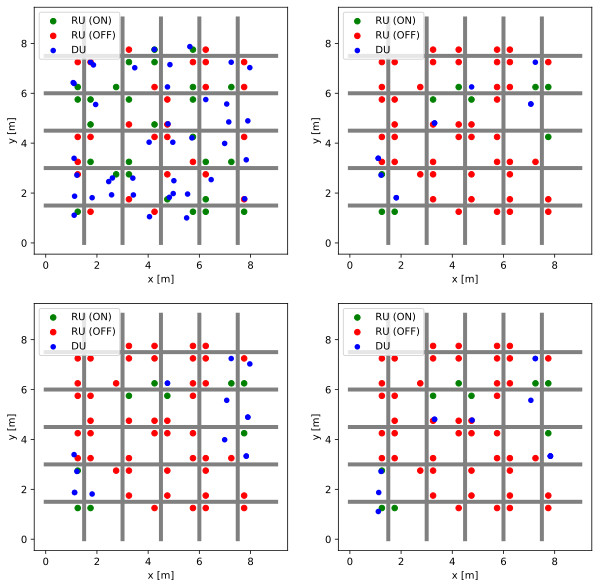

In [387]:
fig, (ax1, ax2) = plt.subplots(2, 2)

JP_LIST = gen_jp(pairs)
RU_LIST = gen_ru(pairs)
DU_LIST = gen_du(JP_LIST)
P_P = rand_P(9, 4)

draw_current_state(cx, JP_LIST,  RU_LIST,DU_LIST, ax1[0], hide_jp = True)
[NEW_DU, NEW_RU, BEST] = gen_next_iteration(JP_LIST, DU_LIST, RU_LIST, P_P, 100)
draw_current_state(cx, JP_LIST,  NEW_RU, NEW_DU, ax1[1], hide_jp = True)
[NEW_DU, NEW_RU, BEST] = gen_next_iteration(JP_LIST, DU_LIST, RU_LIST,P_P, 100)
draw_current_state(cx, JP_LIST,  NEW_RU, NEW_DU, ax2[0], hide_jp = True)
[NEW_DU, NEW_RU, BEST] = gen_next_iteration(JP_LIST, DU_LIST, RU_LIST,P_P, 100)
draw_current_state(cx, JP_LIST,  NEW_RU, NEW_DU, ax2[1], hide_jp = True)
fig.savefig("result.png")
plt.show()